<h1 style = "text-align: center; ">What influences a VW Golf price?</h1>
<h2 style = "text-align: center; ">ST445 - Managing and Visualizing Data</h2>
<h2 style = "text-align: center; ">Candidate IDs: 38682, 50450, 44051</h3>


##### Overview
##### I. Notebook preparation
##### II. Introduction: Research Question + Data Choice
##### III. Data acquisition
        a. UK used cars data (Kaggle API) + EDA (Plot Car Makes over years and price average) (Plot VW Golf)
        b. Economic factors (Webscraping)
        c. Environmental factors (manual PDF extraction)
##### IV. Data Visualization
        a. Price vs. Car Data (Heat Map, Correlation Matrix)
        b. Price vs. Economic Factors (??)
        c. Price vs. Environmental Factors (??)
        d. choose most influential factors (max 3)
##### V. Data Modeling
        a. Model Linear Regression on 3 best variables
##### VI. Conclusion

![Volkswagen Golf](https://m.atcdn.co.uk/vms/media/w980/2fa3b55ab44d4744969f968b5727c8d2.jpg)

## I. Notebook preparation

Our complete GitHub repository can be found at the following location: https://github.com/lse-st445/2024-project-data-knows-ball [[Should we put this in the title of our paper??]]

In [2]:
# Import relevant packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import numpy as np
import os
import zipfile
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# Install lxml with conda install anaconda::lxml to use HMTL and XML with Python
# conda install openpyxl

After importing all necessary libararies, we set the standard settings for the notebook regarding the plot sizes of visualiasing our data.

In [3]:
# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Size of matplotlib figures that contain subplots
fizsize_with_subplots = (10, 5)

# Size of matplotlib histogram bins
bin_size = 10

## II. Introduction and data description

A friend of ours approached us and wants to sell his old used car, being a VW Golf. He was excited about the Data Science programme at LSE and was convinced that we can leverage our Data Science skills to help him understand the UK used-car market better. In general, he wants  to have more knowledge about what influences the UK used-car market overall. Seeing as though our friend has a VW Golf, it would be useful for us to shed light on which factors effect this specific segment of the market as well. Finally, he would like to have a rough estimate of a sales price.

To start the research, we had the hypothesis that next to the UK used cars data describing the car like mileage or engine sizes, economic and environmental factors may play a crucial role of influences on the UK used cars market. Thus we used the following datasets in order to derive a structured answer report for our friend. \n",

1. ALL UK used cars: UK Sales + Economic Data
   [[Peter description]]
3. SAMPLE UK used cars data: 100,000 UK Used Car Data set
   This dataset is derived via an API from the data website Kaggle. It includes around 100k used cars in the UK which were websricped from various used cars marketplaces throughout the UK.\n",
4. GOLF UK used cars data: VW Golf emissions data
   This data contains the emissions data of different VW Golf generations and engine types, which are derived directly from VW emission reports. 

## III. Data acquisition

### III. a) ALL: UK Office of National Statistics (ONS)

Webscrapping: Unemployment rate and CPIH (time series economic data)

In [112]:
# Write function for webscrapping data from the UK Office of National Statistics
def webscrape_ONS(url):
    '''
    This function webscrapes various tables from the UK ONS and seperates the data 
    into distinct dataframes based on the given periodicity: year, quarter, or month.
    ----------
    Args:
        url: The UK Office of National Statistics url from which to webscrabe the table
    ----------
    Returns:        
        ons_year_df: Dataframe of UK ONS data at the yearly level
        ons_quarter_df: Dataframe of UK ONS data at the quarterly level
        ons_month_df: Dataframe of UK ONS data at the monthly level
    '''
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "lxml")

    # Save the table headers to later set as column names for the dataframes
    table_headers = soup.find_all("th")
    table_headers = table_headers[0:2] # We only need the first two columns of data from the ONS
    table_headers = [t.text for t in table_headers]

    ons_data = []

    # Identify and append all webscrapped rows of the ONS table into a dataframe
    for i, row in enumerate(soup.find_all("tr")[2:]): # The frist two rows of ONS tables are headers
        try:
            period, value = row.find_all("td")[0:2] # We only need the first two columns of data from the ONS
            ons_data.append([period.text, value.text])
        except:
            print("Error parsing row #{}".format(i))

    ons_df = pd.DataFrame(ons_data, columns = table_headers)

    # Make the "Value" column data type float instead of string as it was webscrapped
    ons_df = ons_df.astype({"Value": float})

    # Split the data into separate dataframes based on periodicity (year/quarter/month)
    ons_year_df = ons_df[ons_df["Period"].str.len() == 4].reset_index(drop = True) # Year periods will have 4 characters (e.g., "2020")
    ons_quarter_df = ons_df[ons_df["Period"].str.len() == 7].reset_index(drop = True) # Quarter periods will have 7 characters (e.g., "2020 Q1")
    ons_month_df = ons_df[ons_df["Period"].str.len() == 8].reset_index(drop = True) # Month periods will have 8 characters (e.g., "2020 JAN")

    # For dataframes at the yearly level, make year an int type instead of string as it was webscrapped
    ons_year_df = ons_year_df.astype({"Period": int})
    
    # Ensure that all rows present in the original ONS table are present in the three dataframes split based on periodicity
    split_df_len = sum([len(ons_year_df), len(ons_quarter_df), len(ons_month_df)])
    orig_df_len = len(ons_data)
    assert split_df_len == orig_df_len, "ERROR: Not all rows from original ONS table present in corresponding year/quarter/month dataframes"

    return ons_year_df, ons_quarter_df, ons_month_df


In [113]:
# Webscrape UK unemployment and CPIH data tables from the ONS
url_uk_unemp = "https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms"
url_uk_cpih = "https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23"

uk_unemp_year_df, uk_unemp_quarter_df, uk_unemp_month_df = webscrape_ONS(url_uk_unemp)
uk_cpih_year_df, uk_cpih_quarter_df, uk_cpih_month_df = webscrape_ONS(url_uk_cpih)


Current datasets that we have:

UK national unemployment data at the year (1971-2023), quarter (1971Q1-2023Q3), and month (1971FEB-2024SEP) level. <br>
Webscrapped from UK Office of National Statistics: https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms <br>
**uk_unemp_year_df**, **uk_unemp_quarter_df**, **uk_unemp_month_df**

UK national CPIH data at the year (1989-2024), quarter (1989Q1-2024Q4), and month (1989JAN-2024DEC) level. <br>
Webscrapped from UK Office of National Statistics: https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23 <br>
**uk_cpih_year_df**, **uk_cpih_quarter_df**, **uk_cpih_month_df**


[[Description of what visualizations we decided to include and why]]

### III. b) SAMPLE: UK 100k Cars Data

Kaggle API for the data set "100,000 UK Used Cars Data set"

In the first part of our data acquisition, we are focusing on gathering as much used car data as possible for understanding the UK used cars landscape. After that, we can further focus on the VW Golf data as an example car which is one of the most used cars in the UK. 

To acquire UK used cars data, the choice was to work with Kaggle since several datasets for UK used cars are available on the platform which are ready to be worked with. In order to work with the data, we are using the Kaggle API to access the data via a download. This initiated to download the relevant .csv files for our work with the UK used cars landscape. 

In [2]:
# Use Kaggle API to access the relevant dataset
import kaggle

# reading API key from txt file
with open("st445_api_key.txt", "r") as file:
    api_key = file.read().strip()  # .strip() to remove extra newline/whitespace

kaggle.api.authenticate()
# kaggle.api.dataset_download_files("adityadesai13/used-car-dataset-ford-and-mercedes", path=".", unzip=True)
kaggle.api.dataset_download_files(f"{api_key}", path=".", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes


In the following the data gathered from the Kaggle dataset was uploaded into the github repository from where we are loading it into sepearte dataframes. Ultimately all cars data, which are seperated into the makes by .csv files, are merged alltogether into one lareg dataframe allowing us to perform EDA on the UK used cars landscape. 

In [71]:
# Load retrieved data into Dataframes and modify
uk_cars_audi = pd.read_csv("audi.csv")
uk_cars_audi["Make"] = "Audi"
uk_cars_bmw = pd.read_csv("bmw.csv") 
uk_cars_bmw["Make"] = "BMW"
uk_cars_ford = pd.read_csv("ford.csv")
uk_cars_ford["Make"] = "Ford"
uk_cars_hyundai = pd.read_csv("hyundi.csv")
uk_cars_hyundai["Make"] = "Hyundai"
uk_cars_mercedes = pd.read_csv("skoda.csv")
uk_cars_mercedes["Make"] = "Mercedes"
uk_cars_skoda = pd.read_csv("skoda.csv")
uk_cars_skoda["Make"] = "Skoda"
uk_cars_toyota = pd.read_csv("toyota.csv")
uk_cars_toyota["Make"] = "Toyota"
uk_cars_vauxhall = pd.read_csv("vauxhall.csv")
uk_cars_vauxhall["Make"] = "Vauxhall"
uk_cars_vw = pd.read_csv("vw.csv")
uk_cars_vw["Make"] = "VW"

# Merge to one DataFrame
uk_cars_make = [uk_cars_audi, uk_cars_bmw, uk_cars_ford, 
                uk_cars_hyundai, uk_cars_mercedes, uk_cars_skoda, 
                uk_cars_toyota, uk_cars_vauxhall, uk_cars_vw]
uk_cars_data = pd.concat(uk_cars_make)

In [72]:
display(uk_cars_data)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make,tax(£)
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,Audi,NaN
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,Audi,NaN
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,Audi,NaN
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,Audi,NaN
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,Audi,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,VW,NaN
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,VW,NaN
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,VW,NaN
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,VW,NaN


We do have to make some modifications and clean up to the make main uk_cars_data dataframe in order to make it ready to be worked with. 
1. We need to reset the indexes, since we have 92.335 cars and not ca. 15k (this is due to merging separate dataframes and their indexes)
2. Some cars' road taxes are stated seperately in the column "tax (£)", altough all .csv files are formatted with the "tax" column. Thus we need to merge both, since the original "tax" column is stated in GBP £
3. We want to add a column to know the respective Make in the overview dataframe uk_cars_data (and moving it to the first column of the dataframe)
4. We need a standardized price index for price/mileage to be able to compare the cars with different mileages

In [73]:
# 1. Modifying the indexes of the dataframe so we can work with it
number_of_cars = len(uk_cars_data)
new_indexes = list(range(0, number_of_cars))
uk_cars_data = uk_cars_data.reset_index(drop=True)
uk_cars_data = uk_cars_data.reindex(index=new_indexes)

# 2. Adjusting the column Tax(£)
if 'tax' not in uk_cars_data.columns:
    uk_cars_data['tax'] = None
uk_cars_data['tax'] = uk_cars_data['tax'].combine_first(uk_cars_data['tax(£)'])
uk_cars_data = uk_cars_data.drop(columns='tax(£)')

# 3. Make of the cars to the beginning of the dataframe
columns_order = ["Make"] + [col for col in uk_cars_data.columns if col != "Make"]
uk_cars_data = uk_cars_data[columns_order]

# 4. Add another column with the comparison index price/mileage
uk_cars_data["price/mileage"] = uk_cars_data["price"]/uk_cars_data["mileage"]

In [74]:
display(uk_cars_data)

,Make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,price/mileage
0,Audi,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,0.794407
1,Audi,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,0.455763
2,Audi,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,0.367328
3,Audi,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,0.647349
4,Audi,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,8.658659
...,...,...,...,...,...,...,...,...,...,...,...
92330,VW,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,0.080946
92331,VW,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,0.020420
92332,VW,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,0.022714
92333,VW,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,0.015114


##### III.a.ii. EDA of UK used cars data
Here we are performing explanatory data analysis to understand the UK used cars landscape better by looking into the dataframe more closely.

In [75]:
# 1. Generate Overview of the main dataframe
uk_cars_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92335 entries, 0 to 92334
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           92335 non-null  object 
 1   model          92335 non-null  object 
 2   year           92335 non-null  int64  
 3   price          92335 non-null  int64  
 4   transmission   92335 non-null  object 
 5   mileage        92335 non-null  int64  
 6   fuelType       92335 non-null  object 
 7   tax            92335 non-null  float64
 8   mpg            92335 non-null  float64
 9   engineSize     92335 non-null  float64
 10  price/mileage  92335 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 8.5+ MB


In [76]:
# 2. Understand how many values we have per category
unique_counts = uk_cars_data.nunique()
print(unique_counts)

Make                 9
model              168
year                27
price            11271
transmission         4
mileage          39387
fuelType             5
tax                 47
mpg                187
engineSize          32
price/mileage    81904
dtype: int64


In order to be consistent when deriving insights about the different car makes, we want to stick to the same color palette when desciribing specific car makes so it is easier to compare different data charts and data visualisations.

In [77]:
# Create a list of unique car makes and corresponding colors
unique_makes = uk_cars_data["Make"].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_makes))
color_map = dict(zip(unique_makes, palette))

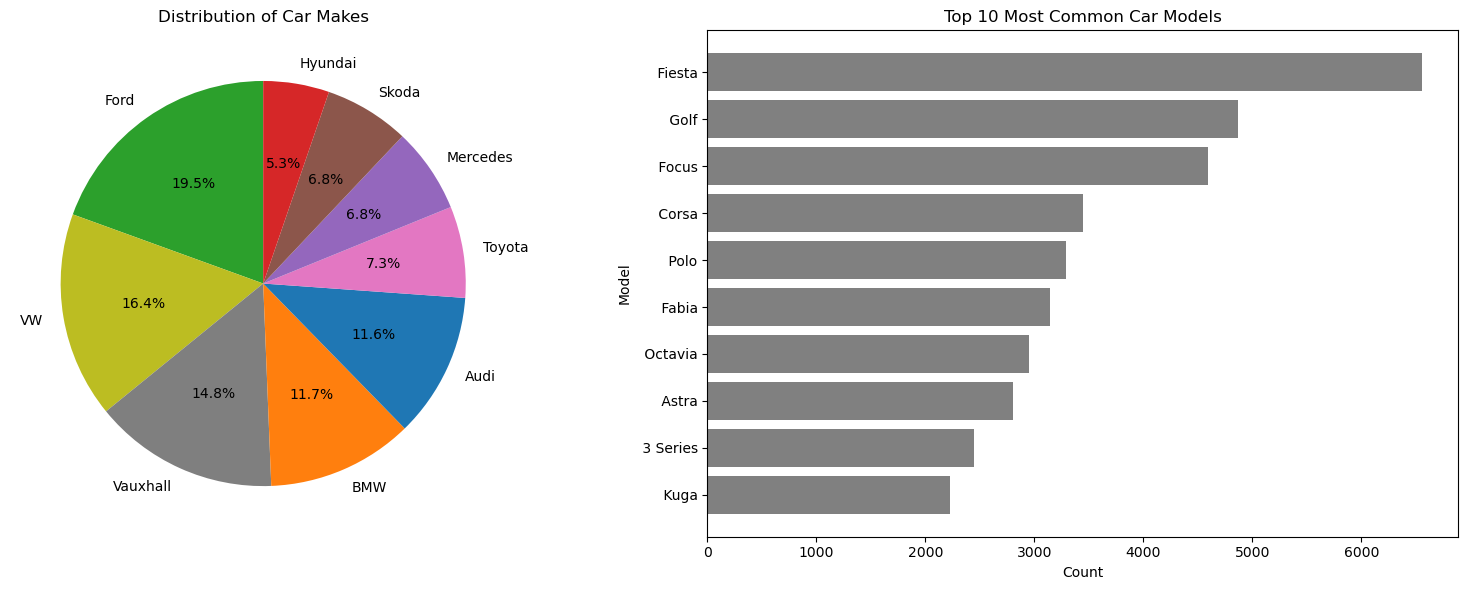

In [78]:
# 3. Overview of car makes and models

# Create a list of unique car makes
unique_makes = uk_cars_data["Make"].unique()

# Count the occurrences of each make and top 10 models
make_counts = uk_cars_data["Make"].value_counts()
model_counts = uk_cars_data["model"].value_counts()
top_10_models = model_counts.head(10)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the pie chart in the first subplot
axes[0].pie(make_counts, labels=make_counts.index, autopct='%1.1f%%', startangle=90, colors=[color_map[make] for make in make_counts.index])
axes[0].set_title("Distribution of Car Makes")

# Plot the horizontal bar chart in the second subplot
axes[1].barh(top_10_models.index, top_10_models.values, color=[color_map.get(make, "gray") for make in top_10_models.index])
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Model")
axes[1].set_title("Top 10 Most Common Car Models")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


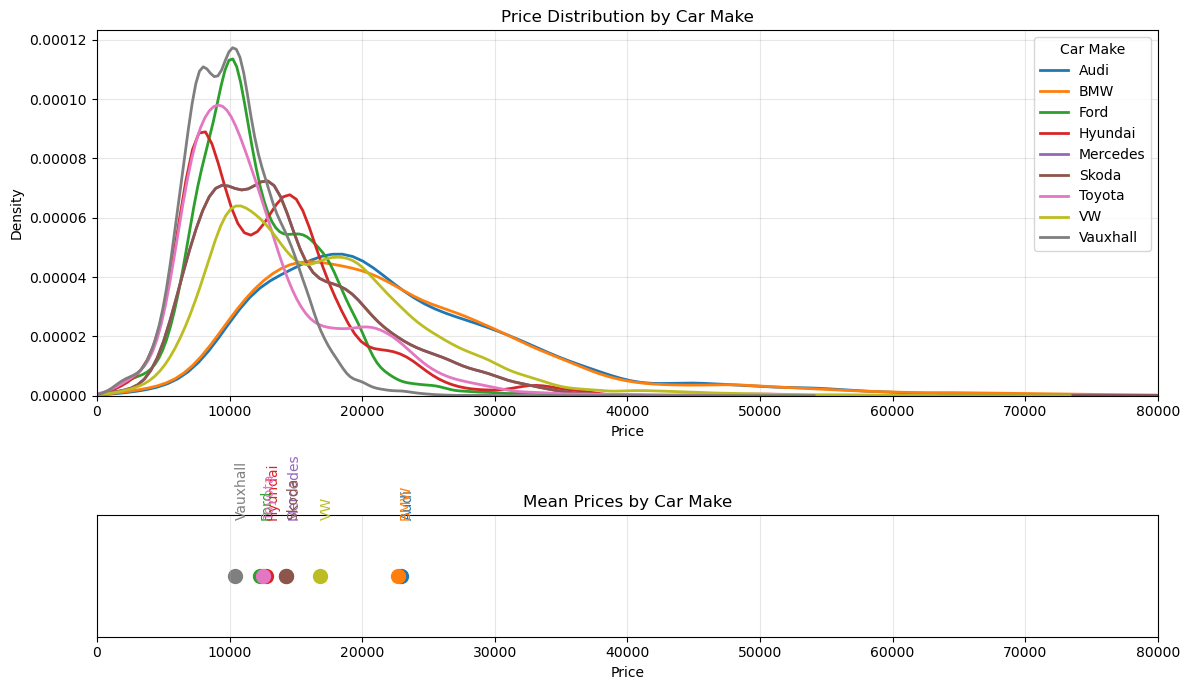

In [79]:
# 4. Clustering into lower, mid, higher segment using price

# Calculate mean prices for each make
make_means = uk_cars_data.groupby("Make")["price"].mean()

# Filter data for the makes in make_means
filtered_data = uk_cars_data[uk_cars_data["Make"].isin(make_means.index)]

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [3, 1]})

# First plot: KDE curves
for make in make_means.index:
    sns.kdeplot(data=filtered_data[filtered_data["Make"] == make], x="price", label=make, ax=axes[0], linewidth=2, color=color_map[make])
axes[0].set_title("Price Distribution by Car Make")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Density")
axes[0].legend(title="Car Make")
axes[0].grid(alpha=0.3)
axes[0].set_xlim((0, 80000))  # Set x-axis range for KDE plot

# Second plot: Mean prices on a single-dimensional line
for make in make_means.index:
    axes[1].scatter(make_means[make], 0, color=color_map[make], s=100, label=make)
axes[1].set_yticks([])  # Remove y-axis ticks for clarity
axes[1].set_xlim((0, 80000))  # Match x-axis range for the mean plot
axes[1].set_title("Mean Prices by Car Make")
axes[1].set_xlabel("Price")
axes[1].grid(alpha=0.3)

# Annotate means with car make labels
for make, mean in make_means.items():
    axes[1].text(mean, 0.05, make, rotation=90, va='bottom', fontsize=10, color=color_map[make])

plt.tight_layout()
plt.show()

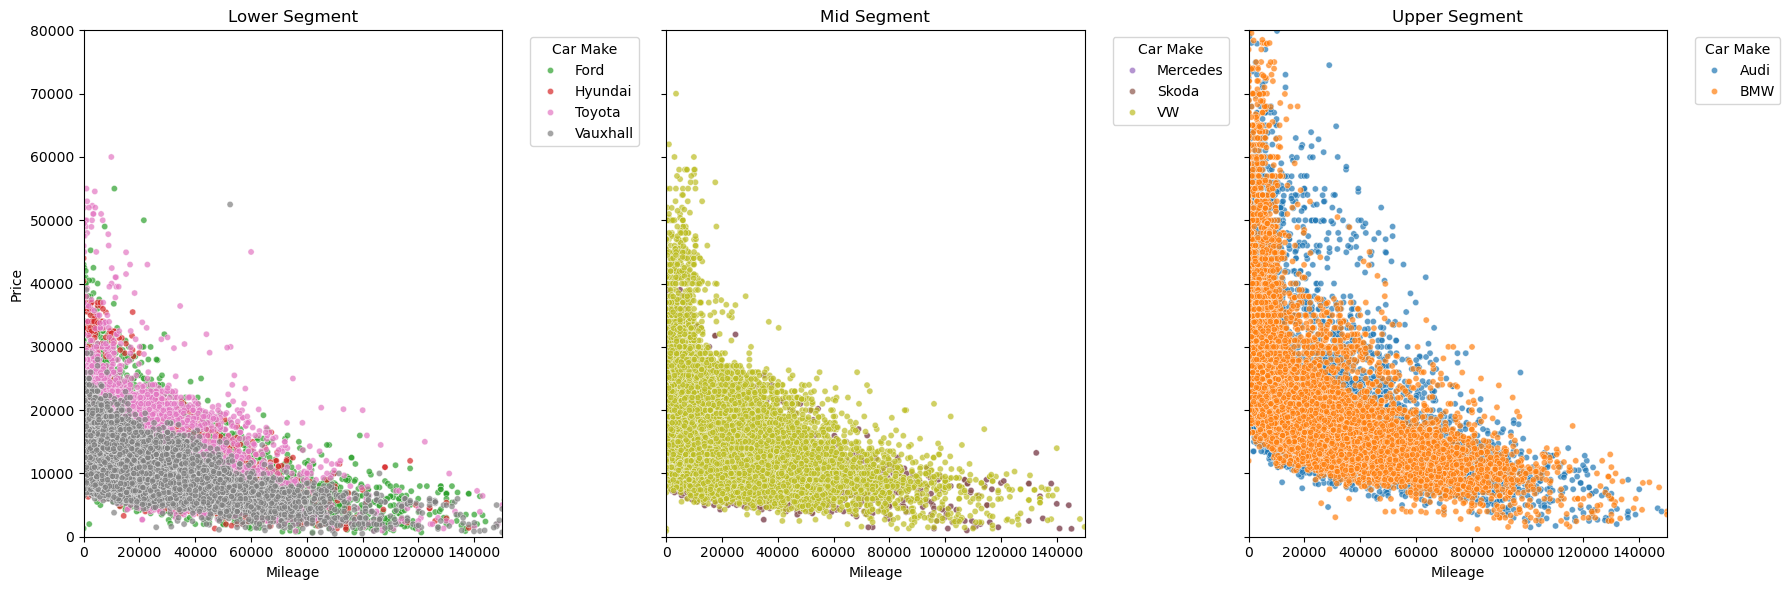

In [80]:
# Define the segments and their corresponding makes
segments = {
    "Lower Segment": ["Vauxhall", "Ford", "Toyota", "Hyundai"],
    "Mid Segment": ["Skoda", "Mercedes", "VW"],
    "Upper Segment": ["Audi", "BMW"]
}

# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot scatter plots for each segment
for idx, (segment_name, makes) in enumerate(segments.items()):
    # Filter data for the current segment
    segment_data = uk_cars_data[uk_cars_data["Make"].isin(makes)]
    sns.scatterplot(data=segment_data, x="mileage", y="price", hue="Make", palette=color_map, alpha=0.7, s=20, ax=axes[idx])
    
    # Set plot attributes
    axes[idx].set_xlim(0, 150000)
    axes[idx].set_ylim(0, 80000)
    axes[idx].set_title(segment_name)
    axes[idx].set_xlabel("Mileage")
    axes[idx].set_ylabel("Price")
    axes[idx].legend(title="Car Make", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


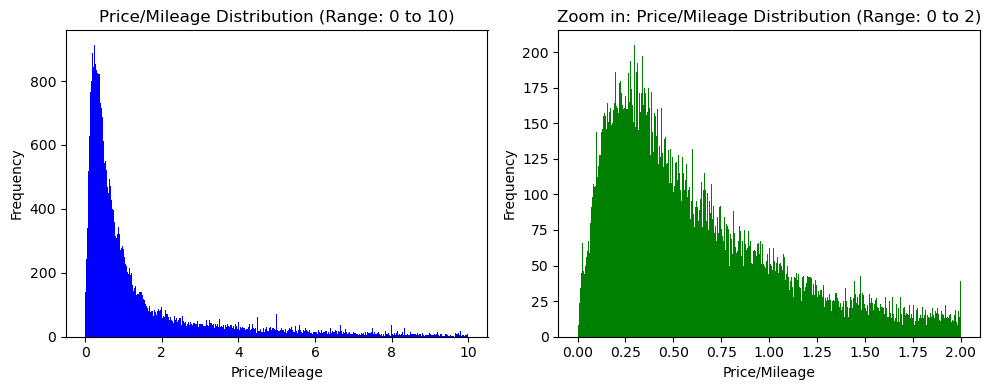

In [81]:
# 5. Distribrution of Price/Mileage
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# First histogram
axes[0].hist(uk_cars_data["price/mileage"], bins=1000, range=(0, 10), color='blue')
axes[0].set_title("Price/Mileage Distribution (Range: 0 to 10)")
axes[0].set_xlabel("Price/Mileage")
axes[0].set_ylabel("Frequency")

# Second histogram
axes[1].hist(uk_cars_data["price/mileage"], bins=1000, range=(0, 2), color='green')
axes[1].set_title("Zoom in: Price/Mileage Distribution (Range: 0 to 2)")
axes[1].set_xlabel("Price/Mileage")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

[[Description of what visualizations we decided to include and why]]

### III. c) GOLF: Environmental factors of VW Golf CO2 Emissions

Finally, in order to explore the effects of emission performance in concert with economic indicators and car specification on used Volkswagen Golf prices, we gather the CO2 emissions data from Volkswagen price and specification guides/catalogues from 2015-2020. This is done by gathering the PDFs published by Volkswagen themselves and manually retrieving the emissions levels for each kind, or setup, of car in the data set. These emissions levels are measured in grams per kilometer of carbon dioxide. Due to limitations in the catalogues themselves, criteria such as fuel type are restricted to just 'Petrol' and 'Diesel', engine size to 1.0, 1.4, 1.5, 1.6, and 2.0 litres, and transmission to 'Manual' and 'Automatic'. 

In [82]:
vw = pd.read_csv("vw.csv")
vw['model'] = vw['model'].str.strip()
vw['fuelType'] = vw['fuelType'].str.strip()
vw['transmission'] = vw['transmission'].str.strip()
golf = vw[vw['model'] == 'Golf']

display(golf)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
733,Golf,2019,17000,Manual,8000,Diesel,145,57.7,1.6
734,Golf,2019,36000,Automatic,4000,Petrol,145,32.8,2.0
735,Golf,2015,19390,Automatic,20031,Petrol,200,40.4,2.0
736,Golf,2019,16290,Automatic,14821,Petrol,145,44.8,1.0
737,Golf,2017,16491,Automatic,20693,Petrol,20,60.1,1.4
...,...,...,...,...,...,...,...,...,...
5591,Golf,2015,11750,Manual,79000,Diesel,20,67.3,2.0
5592,Golf,2016,11950,Automatic,41725,Petrol,30,53.3,1.4
5593,Golf,2017,12950,Automatic,44837,Diesel,20,67.3,2.0
5594,Golf,2014,11299,Manual,25495,Petrol,30,53.3,1.4


In [83]:

def make_setup(row):
    return str(row['year']) + " " + row['transmission'] + " " + row['fuelType'] + " " + str(row['engineSize'])
#golf['setup'] = str(golf['year']) + row['fuelType'].str.strip() + str(row['engineSize'].str.strip())

# Apply the custom function row-wise to concatenate
golf['setup'] = golf.apply(make_setup, axis=1)


/var/folders/wq/pb9dbnn96x5gvb9hxyx_7jgr0000gn/T/ipykernel_6231/3939859616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  golf['setup'] = golf.apply(make_setup, axis=1)


In [84]:
# sort df by year
golf = golf.sort_values(by='year')

# just want 2015-2020
golf = golf[golf['year'] > 2014]

# dropping 'Other' and 'Hybrid' fuel types
golf['fuelType'] = golf['fuelType'].str.strip()
golf = golf[golf['fuelType'] != 'Other']
golf = golf[golf['fuelType'] != 'Hybrid']

CPIH is the ONS's best measure of UK inflation given it captures more of the economy than the other two measures. However, given the UK housing system is different to that of any other nation, it is not internationally comparable."

Test edit


SyntaxError: unterminated string literal (detected at line 12) (2910911932.py, line 12)

In [ ]:

golf = golf[golf['engineSize'] != 0.0]

# dropping semi-auto transmission
golf = golf[golf['transmission'] != 'Semi-Auto']

In [ ]:
vw = pd.read_csv("vw.csv")
vw['model'] = vw['model'].str.strip()
vw['fuelType'] = vw['fuelType'].str.strip()
vw['transmission'] = vw['transmission'].str.strip()
golf = vw[vw['model'] == 'Golf']

display(golf)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
733,Golf,2019,17000,Manual,8000,Diesel,145,57.7,1.6
734,Golf,2019,36000,Automatic,4000,Petrol,145,32.8,2.0
735,Golf,2015,19390,Automatic,20031,Petrol,200,40.4,2.0
736,Golf,2019,16290,Automatic,14821,Petrol,145,44.8,1.0
737,Golf,2017,16491,Automatic,20693,Petrol,20,60.1,1.4
...,...,...,...,...,...,...,...,...,...
5591,Golf,2015,11750,Manual,79000,Diesel,20,67.3,2.0
5592,Golf,2016,11950,Automatic,41725,Petrol,30,53.3,1.4
5593,Golf,2017,12950,Automatic,44837,Diesel,20,67.3,2.0
5594,Golf,2014,11299,Manual,25495,Petrol,30,53.3,1.4


In [ ]:

def make_setup(row):
    return str(row['year']) + " " + row['transmission'] + " " + row['fuelType'] + " " + str(row['engineSize'])
#golf['setup'] = str(golf['year']) + row['fuelType'].str.strip() + str(row['engineSize'].str.strip())

# Apply the custom function row-wise to concatenate
golf['setup'] = golf.apply(make_setup, axis=1)


/var/folders/wq/pb9dbnn96x5gvb9hxyx_7jgr0000gn/T/ipykernel_6231/3939859616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  golf['setup'] = golf.apply(make_setup, axis=1)


In [ ]:
# sort df by year
golf = golf.sort_values(by='year')

# just want 2015-2020
golf = golf[golf['year'] > 2014]

# dropping 'Other' and 'Hybrid' fuel types
golf['fuelType'] = golf['fuelType'].str.strip()
golf = golf[golf['fuelType'] != 'Other']
golf = golf[golf['fuelType'] != 'Hybrid']


golf = golf[golf['engineSize'] != 0.0]

# dropping semi-auto transmission
golf = golf[golf['transmission'] != 'Semi-Auto']

In [ ]:

emissions_dict = {
    '2015 Manual Petrol 2.0' : 139,
    '2015 Manual Diesel 2.0' : 106,
    '2015 Manual Petrol 1.4' : 120,
    '2015 Manual Diesel 1.6' : 99,
    '2015 Automatic Diesel 1.6' : 102,
    '2015 Automatic Diesel 2.0' : 117,
    '2015 Automatic Petrol 2.0' : 145,
    '2015 Automatic Petrol 1.4' : 116,
    '2015 Manual Petrol 1.2' : 113, 
    '2016 Automatic Diesel 1.6' : 102,
    '2016 Manual Petrol 1.4' : 120, 
    '2016 Manual Diesel 2.0' : 109,
    '2016 Manual Diesel 1.6' : 103,
    '2016 Automatic Petrol 2.0' : 145,
    '2016 Manual Petrol 2.0' : 148,
    '2016 Automatic Diesel 2.0' : 117,
    '2016 Automatic Petrol 1.4' : 120,
    '2016 Manual Petrol 1.0' : 105,
    '2016 Automatic Petrol 1.0' : 103, 
    '2016 Manual Petrol 1.2' : 113,
    '2017 Manual Petrol 1.0' : 105,
    '2017 Manual Diesel 1.6' : 105,
    '2017 Manual Petrol 1.4' : 120, 
    '2017 Manual Petrol 2.0' : 162, 
    '2017 Automatic Petrol 1.4' : 116,
    '2017 Manual Diesel 2.0' : 114, 
    '2017 Automatic Diesel 2.0' : 127,
    '2017 Manual Petrol 1.2' : 113, 
    '2017 Automatic Petrol 2.0' : 160,
    '2017 Automatic Diesel 1.6' : 104,
    '2017 Automatic Petrol 1.0' : 103, 
    '2017 Automatic Diesel 1.4' : 102,
    '2018 Manual Petrol 1.4' : 120,
    '2018 Manual Petrol 2.0' : 148, 
    '2018 Automatic Petrol 2.0' : 148,
    '2018 Manual Petrol 1.0' : 108, 
    '2018 Manual Diesel 1.6' : 106,
    '2018 Manual Diesel 2.0' : 109, 
    '2018 Automatic Petrol 1.4' : 119,
    '2018 Manual Petrol 1.5' : 110, 
    '2018 Automatic Diesel 2.0' : 114,
    '2018 Automatic Petrol 1.5' : 110, 
    '2018 Automatic Diesel 1.6' : 102,
    '2018 Automatic Petrol 1.0' : 108, 
    '2019 Manual Diesel 1.6' : 109,
    '2019 Manual Petrol 1.5' : 130, 
    '2019 Automatic Petrol 1.5' : 130,
    '2019 Manual Petrol 1.0' : 109,
    '2019 Automatic Diesel 2.0' : 116,
    '2019 Manual Diesel 2.0' : 115,
    '2019 Automatic Diesel 1.6' : 104,
    '2019 Automatic Petrol 1.0' : 110, 
    '2020 Manual Diesel 1.6' : 134,
    '2020 Automatic Petrol 1.5' : 145, 
    '2020 Manual Petrol 1.5' : 135,
    '2020 Automatic Diesel 2.0' : 142, 
    '2020 Manual Diesel 2.0' : 137, 
    '2020 Manual Petrol 1.0' : 115
    }

golf['CO2 Emissions'] = golf['setup'].map(emissions_dict).astype("float64")

[[Explanation/interpretation of the visualizations are depicting]]

In [ ]:
type(golf)
golf.dtypes

model             object
year               int64
price              int64
transmission      object
mileage            int64
fuelType          object
tax                int64
mpg              float64
engineSize       float64
setup             object
CO2 Emissions    float64
dtype: object

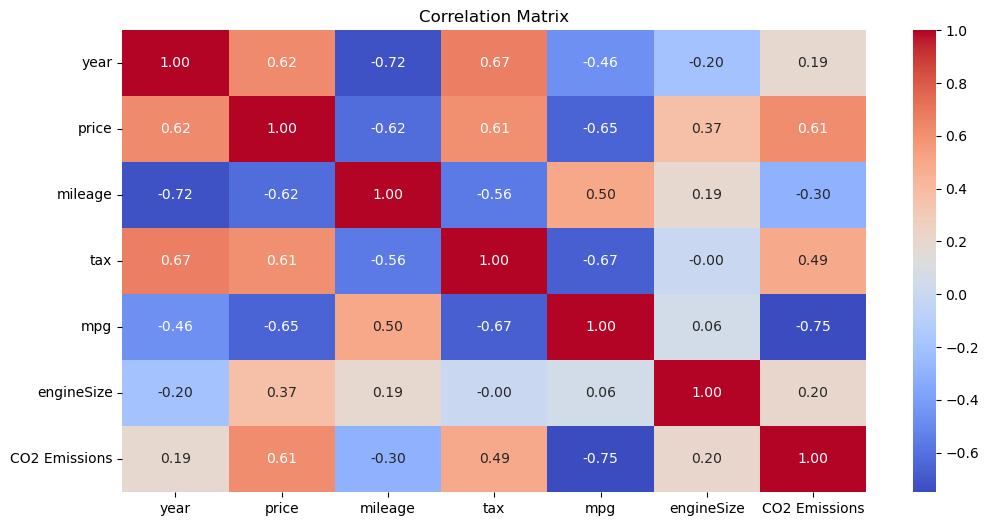

In [ ]:
# Select only numeric columns
golf_numr = golf.select_dtypes(include=['float64', 'int64']).copy()

# Create a matrix to store the correlations
golf_corr = pd.DataFrame(index=golf_numr.columns, columns=golf_numr.columns)

# Calculate the correlations
for i in range(len(golf_numr.columns)):
    for j in range(len(golf_numr.columns)):
        golf_corr.iloc[i, j] = golf_numr.iloc[:, i].corr(golf_numr.iloc[:, j])

# Convert to numeric
golf_corr = golf_corr.apply(pd.to_numeric, errors='coerce')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(golf_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
golf_numr.describe()

,year,price,mileage,tax,mpg,engineSize,CO2 Emissions
count,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,2944.000000
mean,2017.392995,16144.908419,22888.952763,99.521208,55.744184,1.641260,118.342731
std,1.519441,4771.425967,19063.011638,64.748944,10.733399,0.300659,13.878841
min,2015.000000,6000.000000,1.000000,0.000000,32.800000,1.000000,99.000000
25%,2016.000000,12495.000000,7443.750000,30.000000,47.100000,1.500000,109.000000
50%,2017.000000,15489.000000,18539.000000,145.000000,54.300000,1.600000,115.000000
75%,2019.000000,18990.250000,33924.750000,145.000000,62.800000,2.000000,130.000000
max,2020.000000,39950.000000,130400.000000,305.000000,166.200000,2.000000,162.000000


In [ ]:
golf = golf.dropna()
display(golf)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,setup,CO2 Emissions
1913,Golf,2015,9495,Manual,53474,Petrol,30,53.3,1.4,2015 Manual Petrol 1.4,120.0
2478,Golf,2015,10400,Manual,39453,Petrol,30,53.3,1.4,2015 Manual Petrol 1.4,120.0
805,Golf,2015,10698,Manual,38357,Petrol,30,53.3,1.4,2015 Manual Petrol 1.4,120.0
1517,Golf,2015,10650,Manual,19184,Petrol,30,53.3,1.4,2015 Manual Petrol 1.4,120.0
1037,Golf,2015,18498,Manual,25102,Petrol,200,39.8,2.0,2015 Manual Petrol 2.0,139.0
...,...,...,...,...,...,...,...,...,...,...,...
5290,Golf,2020,25000,Manual,1000,Petrol,150,49.6,1.5,2020 Manual Petrol 1.5,135.0
2104,Golf,2020,20995,Manual,899,Petrol,145,47.1,1.5,2020 Manual Petrol 1.5,135.0
2103,Golf,2020,20995,Manual,899,Petrol,145,47.1,1.5,2020 Manual Petrol 1.5,135.0
3283,Golf,2020,21000,Manual,2000,Petrol,145,47.1,1.5,2020 Manual Petrol 1.5,135.0


In [ ]:

emissions_dict = {
    '2015 Manual Petrol 2.0' : 139,
    '2015 Manual Diesel 2.0' : 106,
    '2015 Manual Petrol 1.4' : 120,
    '2015 Manual Diesel 1.6' : 99,
    '2015 Automatic Diesel 1.6' : 102,
    '2015 Automatic Diesel 2.0' : 117,
    '2015 Automatic Petrol 2.0' : 145,
    '2015 Automatic Petrol 1.4' : 116,
    '2015 Manual Petrol 1.2' : 113, 
    '2016 Automatic Diesel 1.6' : 102,
    '2016 Manual Petrol 1.4' : 120, 
    '2016 Manual Diesel 2.0' : 109,
    '2016 Manual Diesel 1.6' : 103,
    '2016 Automatic Petrol 2.0' : 145,
    '2016 Manual Petrol 2.0' : 148,
    '2016 Automatic Diesel 2.0' : 117,
    '2016 Automatic Petrol 1.4' : 120,
    '2016 Manual Petrol 1.0' : 105,
    '2016 Automatic Petrol 1.0' : 103, 
    '2016 Manual Petrol 1.2' : 113,
    '2017 Manual Petrol 1.0' : 105,
    '2017 Manual Diesel 1.6' : 105,
    '2017 Manual Petrol 1.4' : 120, 
    '2017 Manual Petrol 2.0' : 162, 
    '2017 Automatic Petrol 1.4' : 116,
    '2017 Manual Diesel 2.0' : 114, 
    '2017 Automatic Diesel 2.0' : 127,
    '2017 Manual Petrol 1.2' : 113, 
    '2017 Automatic Petrol 2.0' : 160,
    '2017 Automatic Diesel 1.6' : 104,
    '2017 Automatic Petrol 1.0' : 103, 
    '2017 Automatic Diesel 1.4' : 102,
    '2018 Manual Petrol 1.4' : 120,
    '2018 Manual Petrol 2.0' : 148, 
    '2018 Automatic Petrol 2.0' : 148,
    '2018 Manual Petrol 1.0' : 108, 
    '2018 Manual Diesel 1.6' : 106,
    '2018 Manual Diesel 2.0' : 109, 
    '2018 Automatic Petrol 1.4' : 119,
    '2018 Manual Petrol 1.5' : 110, 
    '2018 Automatic Diesel 2.0' : 114,
    '2018 Automatic Petrol 1.5' : 110, 
    '2018 Automatic Diesel 1.6' : 102,
    '2018 Automatic Petrol 1.0' : 108, 
    '2019 Manual Diesel 1.6' : 109,
    '2019 Manual Petrol 1.5' : 130, 
    '2019 Automatic Petrol 1.5' : 130,
    '2019 Manual Petrol 1.0' : 109,
    '2019 Automatic Diesel 2.0' : 116,
    '2019 Manual Diesel 2.0' : 115,
    '2019 Automatic Diesel 1.6' : 104,
    '2019 Automatic Petrol 1.0' : 110, 
    '2020 Manual Diesel 1.6' : 134,
    '2020 Automatic Petrol 1.5' : 145, 
    '2020 Manual Petrol 1.5' : 135,
    '2020 Automatic Diesel 2.0' : 142, 
    '2020 Manual Diesel 2.0' : 137, 
    '2020 Manual Petrol 1.0' : 115
    }

golf['CO2 Emissions'] = golf['setup'].map(emissions_dict).astype("float64")

## IV. Data Visualization

### IV. a) ALL: UK Used cars data

### IV. b) SAMPLE: UK Used cars data

#### IV. b) (i) Clustering into lower, mid, higher segment using price

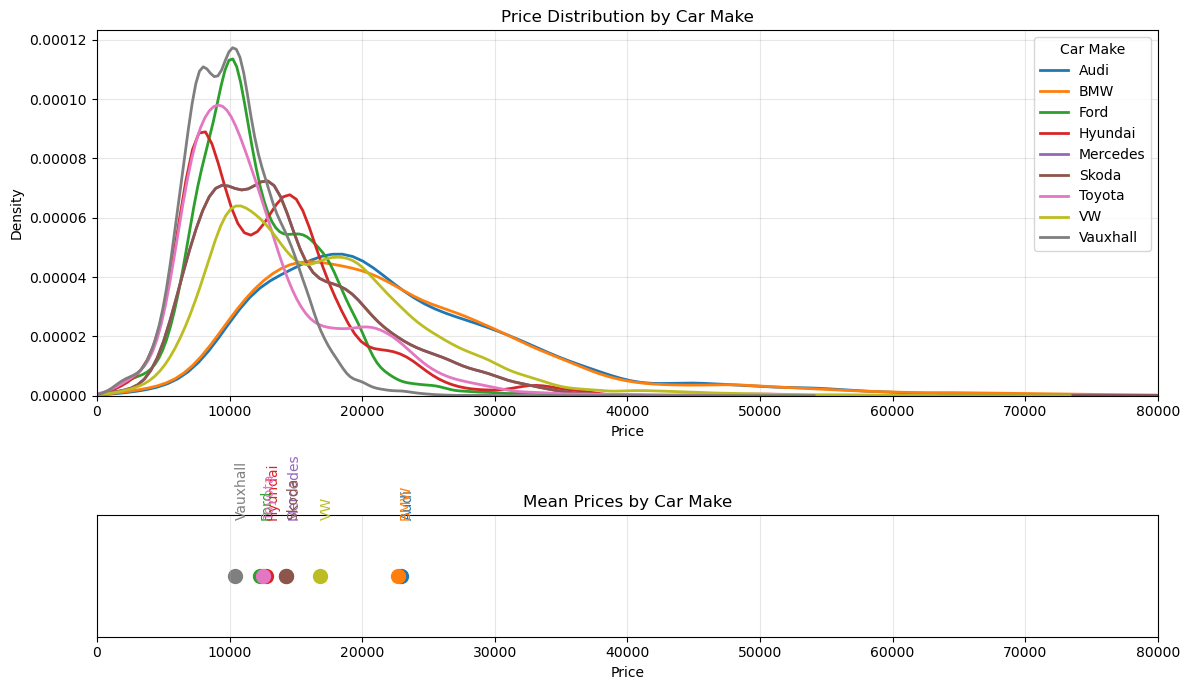

In [ ]:
# Calculate mean prices for each make
make_means = uk_cars_data.groupby("Make")["price"].mean()

# Filter data for the makes in make_means
filtered_data = uk_cars_data[uk_cars_data["Make"].isin(make_means.index)]

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [3, 1]})

# First plot: KDE curves
for make in make_means.index:
    sns.kdeplot(data=filtered_data[filtered_data["Make"] == make], x="price", label=make, ax=axes[0], linewidth=2, color=color_map[make])
axes[0].set_title("Price Distribution by Car Make")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Density")
axes[0].legend(title="Car Make")
axes[0].grid(alpha=0.3)
axes[0].set_xlim((0, 80000))  # Set x-axis range for KDE plot

# Second plot: Mean prices on a single-dimensional line
for make in make_means.index:
    axes[1].scatter(make_means[make], 0, color=color_map[make], s=100, label=make)
axes[1].set_yticks([])  # Remove y-axis ticks for clarity
axes[1].set_xlim((0, 80000))  # Match x-axis range for the mean plot
axes[1].set_title("Mean Prices by Car Make")
axes[1].set_xlabel("Price")
axes[1].grid(alpha=0.3)

# Annotate means with car make labels
for make, mean in make_means.items():
    axes[1].text(mean, 0.05, make, rotation=90, va='bottom', fontsize=10, color=color_map[make])

plt.tight_layout()
plt.show()

#### IV. b) (ii) Define the segments and their corresponding makes

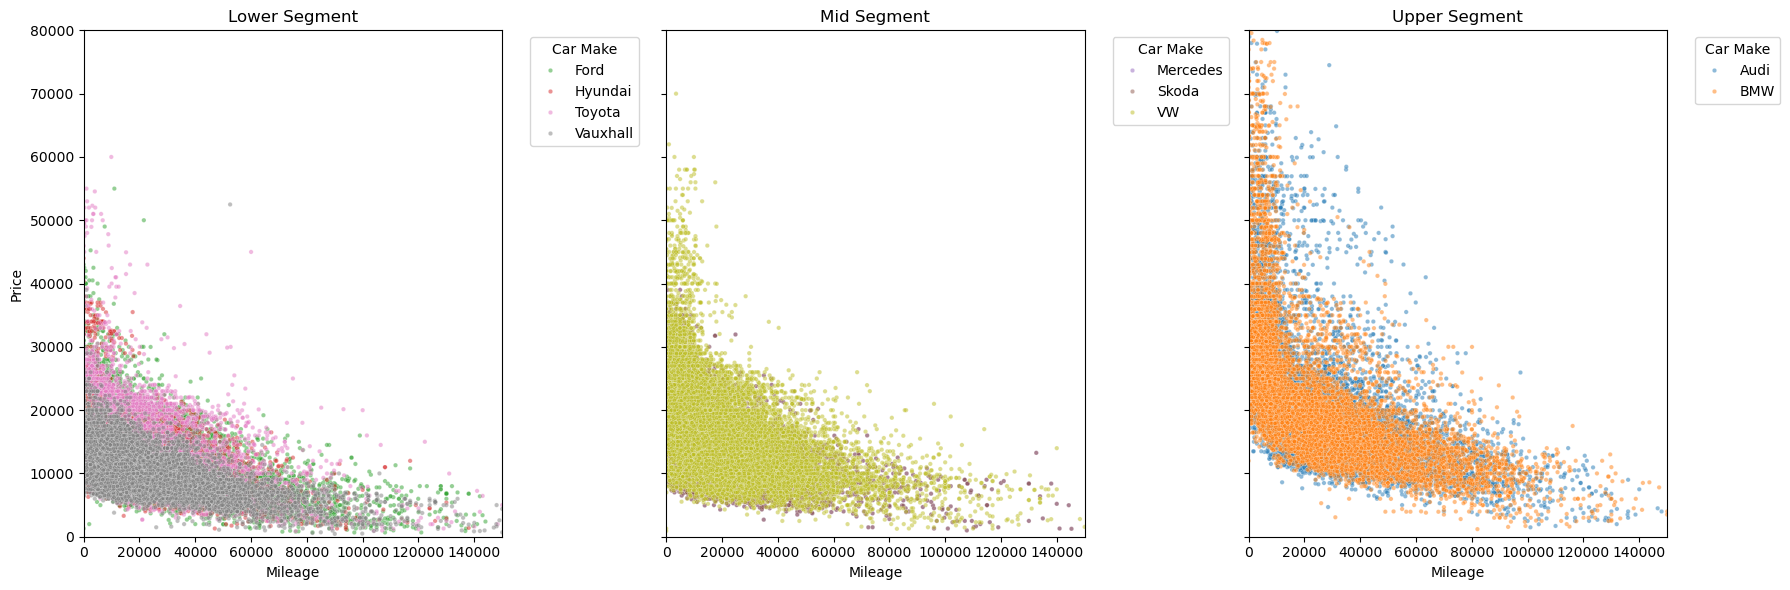

In [ ]:
segments = {
    "Lower Segment": ["Vauxhall", "Ford", "Toyota", "Hyundai"],
    "Mid Segment": ["Skoda", "Mercedes", "VW"],
    "Upper Segment": ["Audi", "BMW"]
}

# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot scatter plots for each segment
for idx, (segment_name, makes) in enumerate(segments.items()):
    # Filter data for the current segment
    segment_data = uk_cars_data[uk_cars_data["Make"].isin(makes)]
    sns.scatterplot(data=segment_data, x="mileage", y="price", hue="Make", palette=color_map, alpha=0.5, s=10, ax=axes[idx])
    
    # Set plot attributes
    axes[idx].set_xlim(0, 150000)
    axes[idx].set_ylim(0, 80000)
    axes[idx].set_title(segment_name)
    axes[idx].set_xlabel("Mileage")
    axes[idx].set_ylabel("Price")
    axes[idx].legend(title="Car Make", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
display(vw)
vw['model'].value_counts()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5
...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0
15153,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2
15154,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4
15155,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2


model
Golf               4863
Polo               3287
Tiguan             1765
Passat              915
Up                  884
T-Roc               733
Touareg             363
Touran              352
T-Cross             300
Golf SV             268
Sharan              260
Arteon              248
Scirocco            242
Amarok              111
Caravelle           101
CC                   95
Tiguan Allspace      91
Beetle               83
Shuttle              61
Caddy Maxi Life      59
Jetta                32
California           15
Caddy Life            8
Eos                   7
Caddy                 6
Caddy Maxi            4
Fox                   4
Name: count, dtype: int64

#### IV. b) (iii) Digger Deeper: Golf vs Other VW Models

In [ ]:
vw['golf_vs_other'] = vw['model'].str.strip().apply(lambda i: 'Other' if i != 'Golf' else i)
display(vw)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,golf_vs_world
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0,Other
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0,Other
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0,Other
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0,Other
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5,Other
...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0,Other
15153,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2,Other
15154,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4,Other
15155,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2,Other


golf_vs_world
Other    10294
Golf      4863
Name: count, dtype: int64

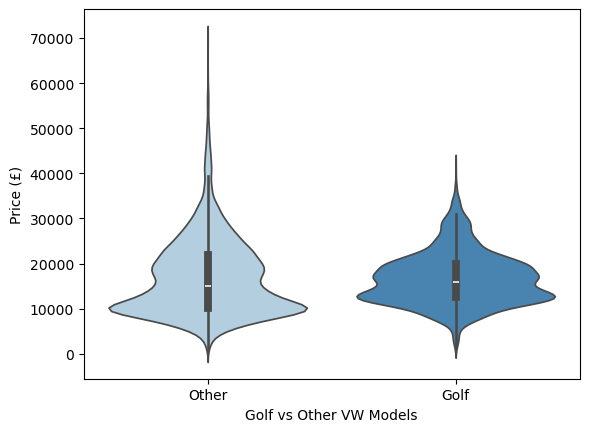

In [ ]:
sns.violinplot(x='golf_vs_other', y='price', hue='golf_vs_other', data=vw, palette="Blues", legend=False)
plt.xlabel("Golf vs Other VW Models")
plt.ylabel("Price (£)")

vw['golf_vs_other'].value_counts()

#### IV. b) (iv) Distribrution of Price/Mileage

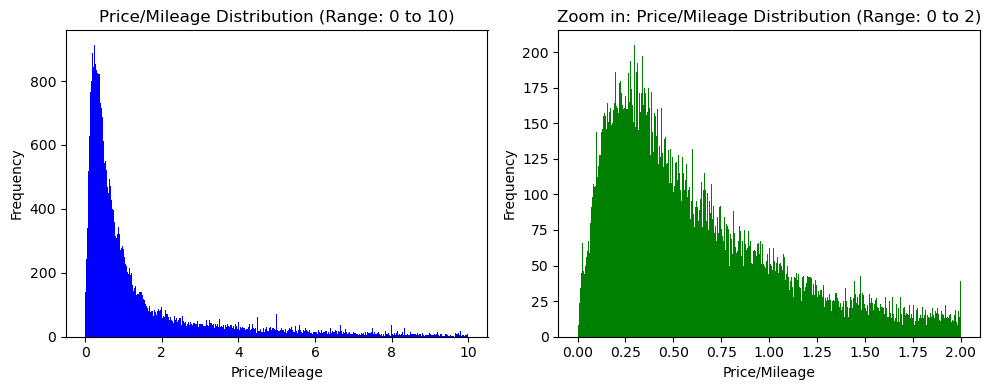

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# General histogram
axes[0].hist(uk_cars_data["price/mileage"], bins=1000, range=(0, 10), color='blue')
axes[0].set_title("Price/Mileage Distribution (Range: 0 to 10)")
axes[0].set_xlabel("Price/Mileage")
axes[0].set_ylabel("Frequency")

# Zoomed-in histogram
axes[1].hist(uk_cars_data["price/mileage"], bins=1000, range=(0, 2), color='green')
axes[1].set_title("Zoom in: Price/Mileage Distribution (Range: 0 to 2)")
axes[1].set_xlabel("Price/Mileage")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

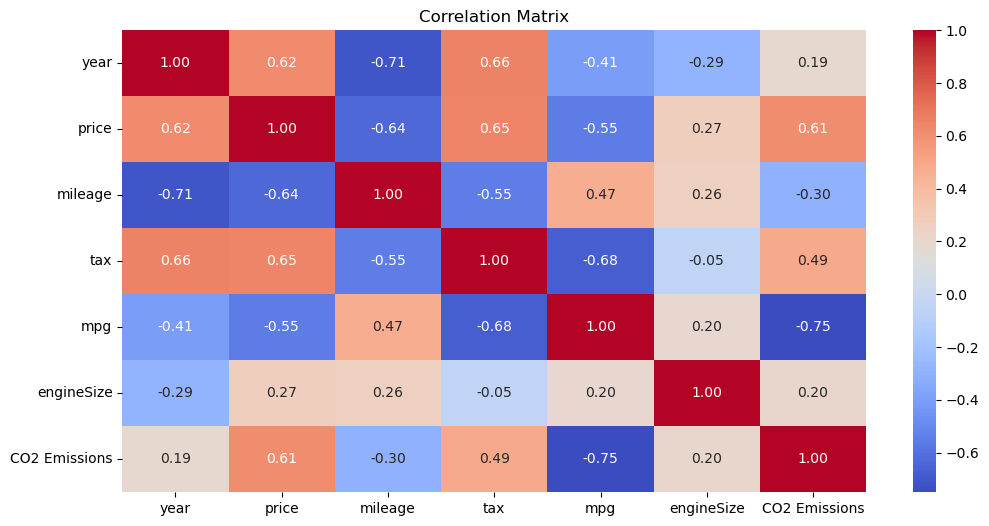

In [ ]:
# Select only numeric columns
golf_numr = golf.select_dtypes(include=['float64', 'int64']).copy()

# Create a matrix to store the correlations
golf_corr = pd.DataFrame(index=golf_numr.columns, columns=golf_numr.columns)

# Calculate the correlations
for i in range(len(golf_numr.columns)):
    for j in range(len(golf_numr.columns)):
        golf_corr.iloc[i, j] = golf_numr.iloc[:, i].corr(golf_numr.iloc[:, j])

# Convert to numeric
golf_corr = golf_corr.apply(pd.to_numeric, errors='coerce')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(golf_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### IV. b) (iv) Digging

### IV. c) GOLF: Price vs. Emissions Data

In [ ]:

golf['bucket'] = pd.cut(golf['price'], 
                        bins=range(min(golf['price']), max(golf['price']), 1000), 
                        right=False, 
                        labels=[i/1000 for i in range(min(golf['price']), max(golf['price']) - 1000, 1000)])
golf = golf.dropna()

#golf['bucket'] = golf['bucket'].astype(int)

golf['bucket'].value_counts()

bucket
12    355
11    300
17    271
13    267
16    217
18    215
14    209
19    201
15    195
10    170
20    130
21    103
9      89
22     58
8      54
23     35
24     27
7      21
25     12
26      5
6       4
27      2
36      1
29      1
28      1
Name: count, dtype: int64

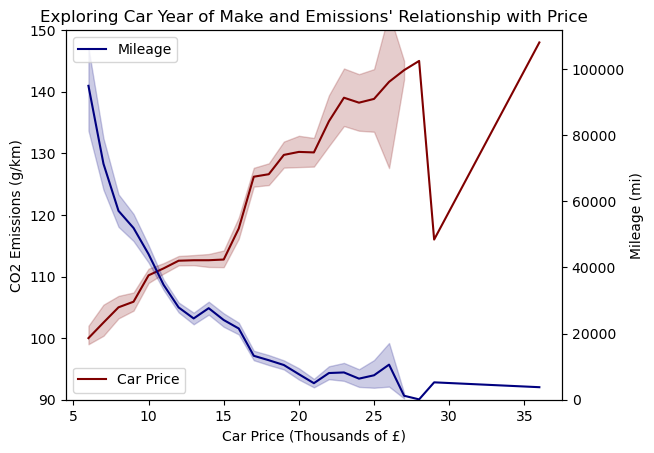

In [ ]:


# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the first variable (y1) using the first y-axis (left)
sns.lineplot(x='bucket', y='CO2 Emissions', data=golf, label='Car Price', color='maroon')
ax1.set_xlabel('Car Price (Thousands of £)')
ax1.set_ylabel('CO2 Emissions (g/km)')
ax1.tick_params(axis='y')
ax1.set_ylim(90,150)
ax1.legend(loc = 'lower left')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the second variable (y2) using the second y-axis (right)
sns.lineplot(x='bucket', y='mileage', data=golf, label='Mileage', color="navy")
ax2.set_ylabel('Mileage (mi)')
ax2.tick_params(axis='y')
#ax2.set_ylim(2014,2020)
ax2.legend(loc = 'upper left')
ax2.hist(golf['bucket'], alpha=.5, density=True)


# Add labels and title
plt.title("Exploring Car Year of Make and Emissions' Relationship with Price")
# Display the plot
plt.show()




Text(20.347222222222214, 0.5, 'Price (£)')

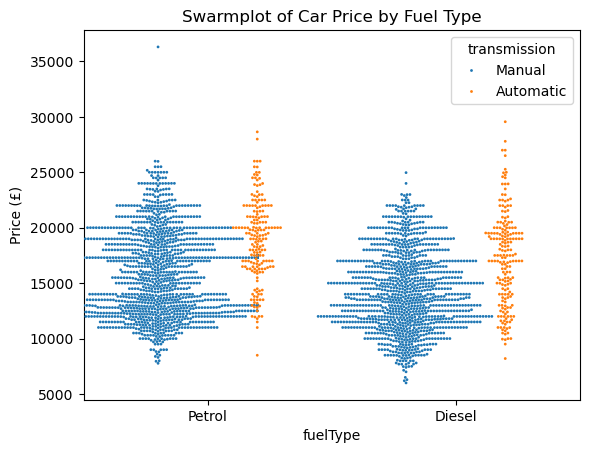

In [ ]:
sns.swarmplot(x='fuelType', y='price', hue='transmission', dodge=True, data=golf, size='CO2 Emissions', s=2)
#plt.xticks([0, 1], [name_1, name_2])
plt.title('Swarmplot of Car Price by Fuel Type')
plt.ylabel('Price (£)')

## V. Data modeling

#### V.a. Model Linear Regression on Golf Car Data Variables

In [ ]:
import statsmodels.api as sm

# Define the predictor variable (price) and independent variables (others)
X = golf_numr.drop(columns=['price'])
y = golf_numr['price']

# Add a constant term to the independent variables (for the intercept)
X = sm.add_constant(X)

# Fit the linear regression model using statsmodels
model = sm.OLS(y, X).fit()

# Generate the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     2104.
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:47:10   Log-Likelihood:                -26089.
No. Observations:                2944   AIC:                         5.219e+04
Df Residuals:                    2937   BIC:                         5.223e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -2.12e+06   7.14e+04    -29.690

## VI. Conclusion